# Homework: train a Nonlinear Classifier

1. Write some code to train the NonlinearClassifier.
2. Create a data loader for the test data and check your model's accuracy on the test data.

If you have time, experiment with how to improve the model. Note: training and validation data can be used to compare models, but test data should be saved until the end as a final check of generalization.

In [2]:
# import libraries
%matplotlib inline

import torch
import torchvision
from torch import nn

import numpy
import matplotlib.pyplot as plt
import time

In [87]:
## Get the MNIST training and testign data from torchvision

training_data = torchvision.datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=torchvision.transforms.ToTensor()
)

test_data = torchvision.datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=torchvision.transforms.ToTensor()
)

In [72]:
## Devide the training data set into trainig and validation using an 80:20 % division.

training_data, validation_data = torch.utils.data.random_split(training_data, [0.8, 0.2], generator=torch.Generator().manual_seed(55))

## Print the number of examples in the train and validation datasets. ALso check the shape of each example
print('MNIST data loaded: train:',len(training_data),' examples, validation: ', len(validation_data), 'examples, test:',len(test_data), 'examples')
print('Input shape', training_data[0][0].shape)

MNIST data loaded: train: 30720  examples, validation:  7680 examples, test: 10000 examples
Input shape torch.Size([1, 28, 28])


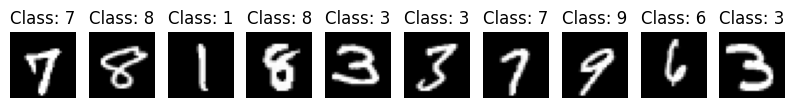

In [73]:
## Vizualize the first 10 training examples
pltsize=1
plt.figure(figsize=(10*pltsize, pltsize))

for i in range(10):
    plt.subplot(1,10,i+1)
    plt.axis('off')
    plt.imshow(numpy.reshape(training_data[i][0], (28, 28)), cmap="gray")
    plt.title('Class: '+str(training_data[i][1]))

In [84]:
## Create data loaders for trainine and validation.

# Define batch size
batch_size = 1024

# The dataloader makes our dataset iterable
train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=batch_size)
val_dataloader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size)

In [75]:
## Define the nonlinear classifier
class NonlinearClassifier(nn.Module):

    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.layers_stack = nn.Sequential(
            nn.Linear(28*28, 50), ## 28x28 is the size of the input
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(50, 50),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(50, 10) # Output is 10 becase of 10 classes
        )

    def forward(self, x):
        x = self.flatten(x) ## x is the input tensor (1x28x28). Here it is flattened to a 1D tensor
        x = self.layers_stack(x)

        return x


The forward function in the provided code defines the forward pass of the NonlinearClassifier neural network model. Here's what it does step by step:

    1. It takes an input tensor x, which represents the input data to the neural network.

    2. It flattens the input tensor x using self.flatten(x). The nn.Flatten() layer reshapes the input tensor into a 1-dimensional tensor. This is necessary because the input to the neural network is typically expected to be a flat vector rather than a multi-dimensional tensor.

    3. It passes the flattened tensor through a sequence of fully connected layers defined by self.layers_stack. This sequence includes two hidden layers with ReLU activation functions (nn.ReLU()) followed by fully connected layers. The first fully connected layer has 50 units, and the second fully connected layer reduces the dimensionality to the output size, which is 10 in this case (since there are 10 classes).

    4. It returns the output tensor x, which represents the output of the neural network after passing through all the layers in the forward function.

In [76]:
## Define device to allow training on GPU
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [77]:
# Create an instance of the nonlinear classifier and print the model
nonlinear_model = NonlinearClassifier() #.to(device)
print(nonlinear_model)

NonlinearClassifier(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (layers_stack): Sequential(
    (0): Linear(in_features=784, out_features=50, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=50, out_features=50, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=50, out_features=10, bias=True)
  )
)


In [78]:
## Define Loss function and optimize
loss_fn = nn.CrossEntropyLoss()
#optimizer = torch.optim.SGD(nonlinear_model.parameters(), lr=0.01)
optimizer = torch.optim.AdamW(nonlinear_model.parameters(), lr=0.01)

In [79]:
## Define function to train the model for one epoch
def train_one_epoch(dataloader, model, loss_fn, optimizer):
    model.train()
    for batch, (X, y) in enumerate(dataloader):

        # pass the data to the GPU
        #X,y = X.to(device),y.to(device)
        # forward pass
        pred = model(X)
        loss = loss_fn(pred, y)

        # backward pass calculates gradients
        loss.backward()

        # take one step with these gradients
        optimizer.step()

        # resets the gradients
        optimizer.zero_grad()

In [80]:
## Define the function to evaluate the model
def evaluate(dataloader, model, loss_fn):
    # Set the model to evaluation mode - some NN pieces behave differently during training
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    loss, correct = 0, 0

    # We can save computation and memory by not calculating gradients here - we aren't optimizing
    with torch.no_grad():
        # loop over all of the batches
        for X, y in dataloader:
            #X,y = X.to(device),y.to(device)
            pred = model(X)
            loss += loss_fn(pred, y).item()
            # how many are correct in this batch? Tracking for accuracy
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    loss /= num_batches
    correct /= size

    accuracy = 100*correct
    return accuracy, loss

In [81]:
## Train the model for 5 epochs
%%time

epochs = 10
for j in range(epochs):
    train_one_epoch(train_dataloader, nonlinear_model, loss_fn, optimizer)

    # checking on the training loss and accuracy once per epoch
    acc, loss = evaluate(train_dataloader, nonlinear_model, loss_fn)
    print(f"Epoch {j}: training loss: {loss}, accuracy: {acc}")

Epoch 0: training loss: 0.3143522381782532, accuracy: 90.45572916666667
Epoch 1: training loss: 0.20506382683912913, accuracy: 93.837890625
Epoch 2: training loss: 0.1636355049908161, accuracy: 95.09114583333333
Epoch 3: training loss: 0.1339673010011514, accuracy: 96.03515625
Epoch 4: training loss: 0.12203378429015478, accuracy: 96.337890625
Epoch 5: training loss: 0.10457645977536838, accuracy: 96.82291666666667
Epoch 6: training loss: 0.09184539106984933, accuracy: 97.22005208333333
Epoch 7: training loss: 0.08314593496421972, accuracy: 97.40559895833333
Epoch 8: training loss: 0.07709618099033833, accuracy: 97.607421875
Epoch 9: training loss: 0.07273649846514066, accuracy: 97.77994791666667
CPU times: user 1min 7s, sys: 215 ms, total: 1min 8s
Wall time: 1min 8s


# Inference

For a better measure of the quality of the model, let's see the model accuracy for the validation data.



In [82]:
acc_val, loss_val = evaluate(val_dataloader, nonlinear_model, loss_fn)
print("Validation loss: %.4f, validation accuracy: %.2f%%" % (loss_val, acc_val))

Validation loss: 0.1415, validation accuracy: 95.87%


Take a look at 10 failed predictions of the model on the validation dataset

Showing max 10 first failures. The predicted class is shown first and the correct class in parentheses.


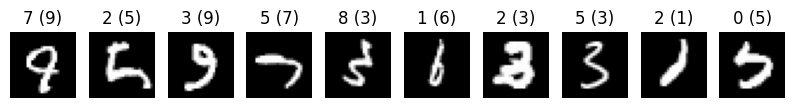

In [83]:
def show_failures(model, dataloader, maxtoshow=10):
    model.eval()
    batch = next(iter(dataloader))

    predictions = model(batch[0])

    rounded = predictions.argmax(1)
    errors = rounded!=batch[1]
    print('Showing max', maxtoshow, 'first failures. '
          'The predicted class is shown first and the correct class in parentheses.')
    ii = 0
    plt.figure(figsize=(maxtoshow, 1))
    for i in range(batch[0].shape[0]):
        if ii>=maxtoshow:
            break
        if errors[i]:
            plt.subplot(1, maxtoshow, ii+1)
            plt.axis('off')
            plt.imshow(batch[0][i,0,:,:], cmap="gray")
            plt.title("%d (%d)" % (rounded[i], batch[1][i]))
            ii = ii + 1

#Use the function
show_failures(nonlinear_model,val_dataloader)

## Create data loader for test data to evaluate the model with it.

In [88]:
## Create data loaders for test data.
# Define batch size
batch_size = 1024

# The dataloader makes our dataset iterable
test_dataloader= torch.utils.data.DataLoader(test_data,batch_size=batch_size)

In [89]:
## Evaluate the model accuracy with the test data
acc_val, loss_val = evaluate(test_dataloader, nonlinear_model, loss_fn)
print("Validation loss: %.4f, validation accuracy: %.2f%%" % (loss_val, acc_val))

Validation loss: 0.1379, validation accuracy: 96.06%
